# Example - Zonal Statistics
This is useful in the case where you want to get regional statistics for a raster.

In [2]:
import geopandas as gpd
import numpy
import rioxarray
import xarray

from geocube.api.core import make_geocube

%matplotlib inline

## Create the data mask by rasterizing the unique ID of the vector data

See docs for [make_geocube](../geocube.rst#make-geocube)

In [4]:
# This assumes you are running this example from a clone of
# https://github.com/corteva/geocube/
# You could also use the full path:
# https://raw.githubusercontent.com/corteva/geocube/master/test/test_data/input/soil_data_group.geojson
ssurgo_data = gpd.read_file(
    "https://raw.githubusercontent.com/corteva/geocube/master/test/test_data/input/soil_data_group.geojson"
)
ssurgo_data = ssurgo_data.loc[ssurgo_data.hzdept_r == 0]
# convert the key to group to the vector data to an integer as that is one of the
# best data types for this type of mapping. If your data is not integer,
# then consider using a mapping of your data to an integer with something
# like a categorical dtype.
ssurgo_data["mukey"] = ssurgo_data.mukey.astype(int)

In [20]:
# load in source elevation data subset relevant for the vector data
elevation = (
    rioxarray.open_rasterio(
        "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n42w091/USGS_13_n42w091.tif",
        masked=True,
    )
    .rio.clip(ssurgo_data.geometry.values, ssurgo_data.crs, from_disk=True)
    .sel(band=1)
    .drop("band")
)
elevation.name = "elevation"

In [21]:
elevation

<xarray.DataArray 'elevation' (y: 178, x: 178)>
array([[173.09681702, 172.82461548, 171.41659546, ..., 171.896698  ,
        172.24406433, 172.13301086],
       [173.20603943, 171.95214844, 170.97846985, ..., 171.87312317,
        172.15046692, 172.13165283],
       [172.48820496, 171.22154236, 170.5309906 , ..., 171.71755981,
        171.81768799, 171.91723633],
       ...,
       [175.06867981, 175.99842834, 176.43412781, ..., 180.79481506,
        181.3999939 , 181.53878784],
       [175.52464294, 176.44433594, 176.834198  , ..., 180.85920715,
        181.29545593, 181.39035034],
       [175.83576965, 176.59727478, 176.98123169, ..., 180.87664795,
        181.30897522, 181.44654846]])
Coordinates:
  * x            (x) float64 -90.6 -90.6 -90.6 -90.6 ... -90.58 -90.58 -90.58
  * y            (y) float64 41.5 41.5 41.5 41.5 ... 41.48 41.48 41.48 41.48
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:          Area
    BandDefinitionKeyword:  *
    DataType:               *
    LAYER_TYPE:             athematic
    RepresentationType:     *
    scale_factor:           1.0
    add_offset:             0.0
    long_name:              Layer_1

In [9]:
out_grid = make_geocube(
    vector_data=ssurgo_data,
    measurements=["mukey"],
    like=elevation,  # ensure the data are on the same grid
)

In [22]:
# merge the two together
out_grid["elevation"] = (elevation.dims, elevation.values, elevation.attrs, elevation.encoding)
out_grid

<xarray.Dataset>
Dimensions:      (y: 178, x: 178)
Coordinates:
  * y            (y) float64 41.5 41.5 41.5 41.5 ... 41.48 41.48 41.48 41.48
  * x            (x) float64 -90.6 -90.6 -90.6 -90.6 ... -90.58 -90.58 -90.58
    spatial_ref  int32 0
Data variables:
    mukey        (y, x) float64 1.988e+05 1.988e+05 ... 1.987e+05 1.987e+05
    elevation    (y, x) float64 173.1 172.8 171.4 170.9 ... 180.9 181.3 181.4

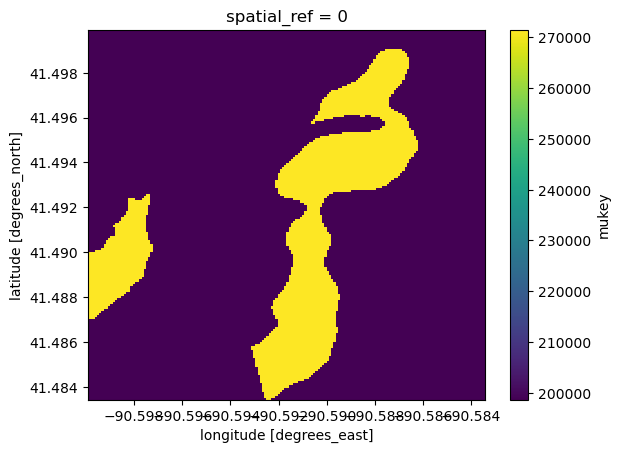

In [24]:
out_grid.mukey.plot.imshow()

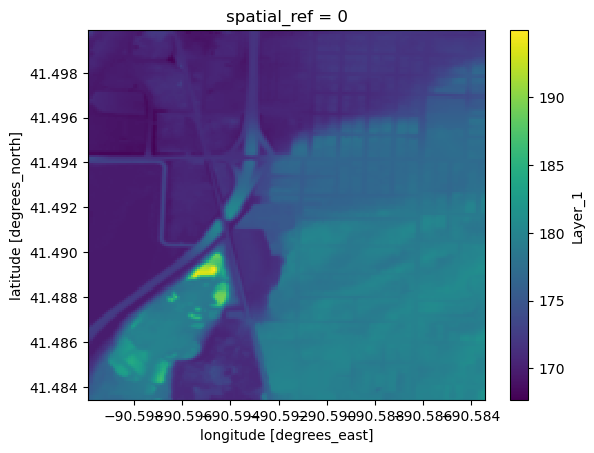

In [12]:
out_grid.elevation.plot()

### Get the elevation statistics of each region using the mask

In [13]:
grouped_elevation = out_grid.drop("spatial_ref").groupby(out_grid.mukey)
grid_mean = grouped_elevation.mean().rename({"elevation": "elevation_mean"})
grid_min = grouped_elevation.min().rename({"elevation": "elevation_min"})
grid_max = grouped_elevation.max().rename({"elevation": "elevation_max"})
grid_std = grouped_elevation.std().rename({"elevation": "elevation_std"})

In [30]:
grouped_elevation

DatasetGroupBy, grouped over 'mukey'
7 groups with labels 1.987e+05, ..., 2.714e+05.

In [25]:
zonal_stats = xarray.merge([grid_mean, grid_min, grid_max, grid_std]).to_dataframe()
zonal_stats

,elevation_mean,elevation_min,elevation_max,elevation_std
mukey,,,,
198692.0,173.920127,169.558762,189.282532,4.235467
198714.0,174.988023,170.244766,179.659058,2.090531
198724.0,180.008519,178.314453,181.538788,0.619666
198750.0,176.335637,169.263535,194.975769,3.932905
198754.0,171.909373,167.691681,186.318939,3.204279
271425.0,169.547460,169.539307,169.804550,0.036148
271431.0,176.757018,170.410980,180.344055,2.749569


In [26]:
ssurgo_data = ssurgo_data.merge(zonal_stats, on="mukey")

KeyError: 'elevation_mean'

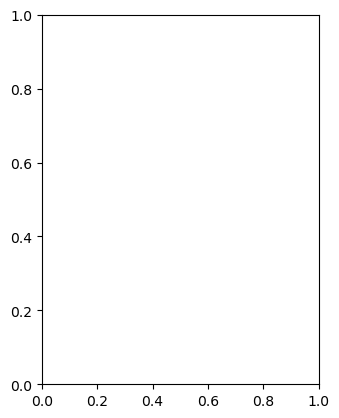

In [27]:
ssurgo_data.plot(column="elevation_mean", legend=True)

<Axes: >

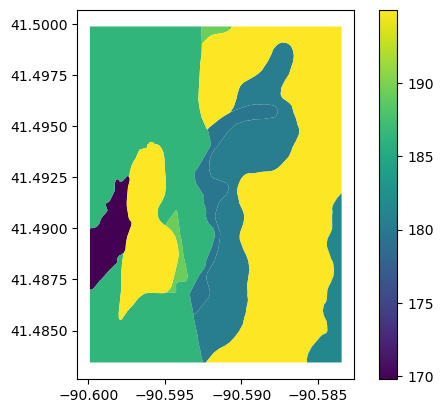

In [ ]:
ssurgo_data.plot(column="elevation_max", legend=True)